In [1]:
from sqlalchemy import create_engine
import pandas.io.sql as psql
from sklearn.model_selection import train_test_split
import pandas as pd
from prophet import Prophet
from config import POSTGRES_ADDRESS, POSTGRES_USERNAME, POSTGRES_PASSWORD, POSTGRES_DBNAME ,POSTGRES_PORT

ModuleNotFoundError: No module named 'prophet'

In [2]:

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
 .format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))


In [3]:
cnx = create_engine(postgres_str)

In [89]:
import pandas as pd 
sales_df = pd.read_csv("monthly_CSB.csv")
#sales_df.reset_index(inplace=True)
sales_df.columns = ['ds', 'y']

In [79]:
df = sales_df.copy()
sales_df.describe()

,y
count,16.000000
mean,609207.250000
std,91935.885861
min,459801.000000
25%,543741.750000
50%,595141.000000
75%,700818.750000
max,746977.000000


In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, random_state=1)

In [81]:
df_train = X_train.copy()
df_train.sort_index(inplace=True)
df_train.head()

,ds,y
0,1/31/21,607477
1,2/28/21,544569
4,5/31/21,735599
5,6/30/21,698272
6,7/31/21,708459


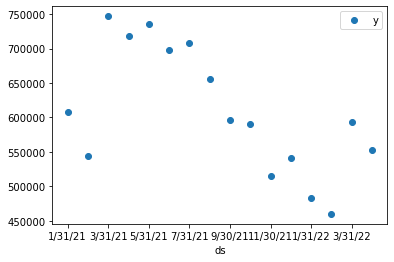

In [82]:
# current order trend is a linear function with seasonality
from matplotlib import pyplot
df.plot(x='ds', y='y', style='o')
pyplot.show() 

In [83]:
#m = Prophet('growth= 'logistic)
m = Prophet(weekly_seasonality=False)
#m.add_seasonality('self_define_cycle',period=1,fourier_order=8,mode='additive')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#m.add_country_holidays(country_name='US')
m.fit(df_train)
# simple model to start with. we can interact with the model to change the parameters e.g logistic growth
# try other timeseries models starting ARIMA, variatios in prophet, etc

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.


In [84]:
future = m.make_future_dataframe(periods=6 , freq='M')
future.tail()

,ds
13,2022-06-30
14,2022-07-31
15,2022-08-31
16,2022-09-30
17,2022-10-31


In [85]:
future['cap'] = 2000 # set the cap to 20k
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
13,2022-06-30,547263.281230,475978.952637,623710.119587
14,2022-07-31,537737.843936,467237.825896,616126.293793
15,2022-08-31,555393.361708,480847.447757,634077.935218
16,2022-09-30,525853.475860,447329.104009,606852.846851
17,2022-10-31,543508.993637,470867.537861,622062.833866


<ipython-input-86-9356221cd325>:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



Text(0.5, 33.0, 'Date')

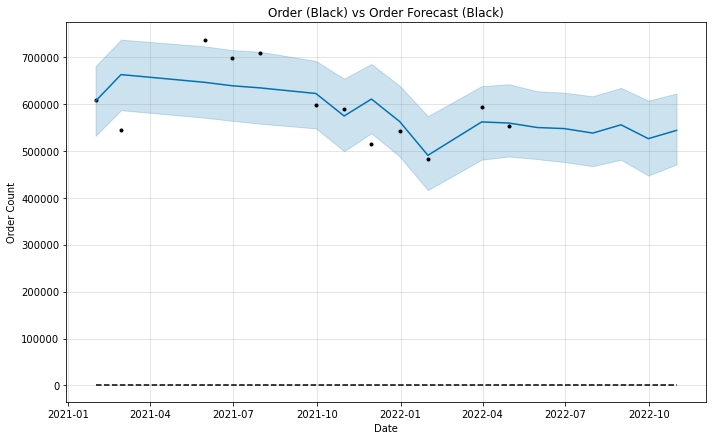

In [86]:
import matplotlib.pyplot as plt
fig1 = m.plot(forecast)
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_title('Order (Black) vs Order Forecast (Black)')
ax1.set_ylabel('Order Count')
ax1.set_xlabel('Date')

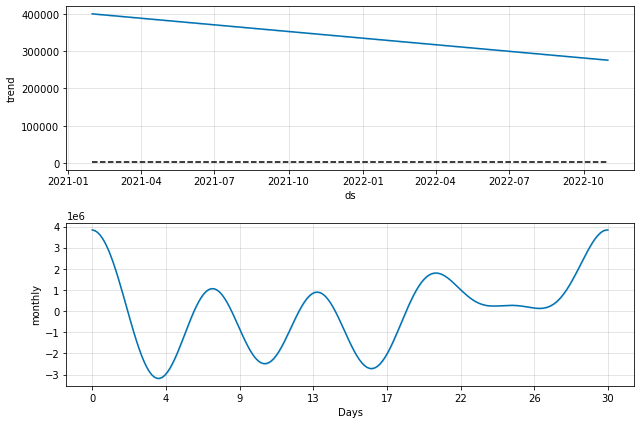

In [87]:
fig2 = m.plot_components(forecast)

In [88]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [15]:
# saving to database so that mico batch will scan and scale up and scale down instances
#postgres_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#postgres_df.to_sql('oph_forecast', cnx, if_exists='replace', index=False)